<a href="https://colab.research.google.com/github/GhiyatsNaufal/Dataset/blob/main/Pertemuan_10_Praktikum_Sistem_Multimedia_Video_Annotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Video Annotation

pada materi ini kita akan melakukan video annotation atau pemberian notasi atau label pada objek di video.

sebelum nya kita import terlebih dahulu library yang akan kita gunakan

In [ ]:
!pip install -U kora

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from kora.drive import upload_public

from glob import glob

import IPython.display as ipd
from tqdm import tqdm

import subprocess

plt.style.use('ggplot')

Video yang akan kita gunakan adalah video pendek orang yang sedang mengemudi yang di hadapanan kanan dan kiri nya terlihat mobil yang sedang parkir dan juga beberapa pejalan kaki.

Objek mobil dan pejalan kaki adalah salah satu objek yang akan di label pada video ini

#mengkonversi video
pada tahapan pertama kit akan melakukan konversi dari yang asalnya ber ektensi mov di rubah ke mp4

In [ ]:
input_file = 'https://api.uinsgd.ac.id/salam/v1/data/026c7465-309f6d33.mov'
subprocess.run(['ffmpeg',
                '-i',
                input_file,
                '-qscale',
                '0',
                '026c7465-309f6d33.mp4',
                '-loglevel',
                'quiet']
              )

CompletedProcess(args=['ffmpeg', '-i', 'https://api.uinsgd.ac.id/salam/v1/data/026c7465-309f6d33.mov', '-qscale', '0', '026c7465-309f6d33.mp4', '-loglevel', 'quiet'], returncode=0)

In [ ]:
!ls -GFlash --color

total 6.5M
4.0K drwxr-xr-x 1 root 4.0K Jun  7 06:24 ./
4.0K drwxr-xr-x 1 root 4.0K Jun  7 06:18 ../
6.4M -rw-r--r-- 1 root 6.4M Jun  7 06:25 026c7465-309f6d33.mp4
4.0K drwxr-xr-x 4 root 4.0K Jun  5 16:30 .config/
4.0K drwxr-xr-x 1 root 4.0K Jun  5 16:31 sample_data/


Kita coba jalankan video hasil konversinya yang sudah bertipe mp4

In [ ]:
url = upload_public('026c7465-309f6d33.mp4')
# then display it
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")

kita capture informasi dari video tersebut mulai dari frame, fps dll

In [ ]:
cap = cv2.VideoCapture('026c7465-309f6d33.mp4')

kita tampilkan jumlah frame atau jumlah gambar pada video tersebut

In [ ]:
cap.get(cv2.CAP_PROP_FRAME_COUNT)

902.0

kita tampilkan resolusi dari video tersebut

In [ ]:
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
print(f'Height {height}, Width {width}')

Height 720.0, Width 1280.0


In [ ]:
# Get frames per second
fps = cap.get(cv2.CAP_PROP_FPS)
print(f'FPS : {fps:0.2f}')

FPS : 59.94


In [ ]:
cap.release()

In [ ]:
cap = cv2.VideoCapture('026c7465-309f6d33.mp4')
ret, img = cap.read()
print(f'Returned {ret} and img of shape {img.shape}')

Returned True and img of shape (720, 1280, 3)


kita buat fungsi untuk menampilkan frame pada video

In [ ]:
## Helper function for plotting opencv images in notebook
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

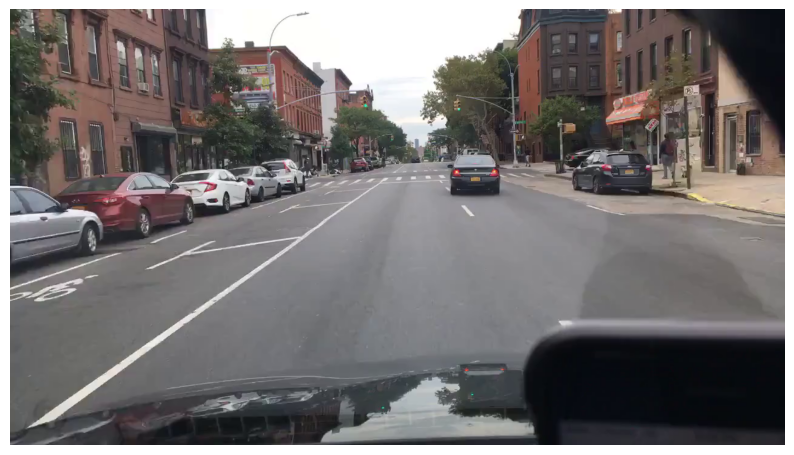

In [ ]:
display_cv2_img(img)

In [ ]:
cap.release()

pada bagian ini kita akan coba tampilkan capture image tiap 100 frame

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(30, 20))
axs = axs.flatten()

cap = cv2.VideoCapture("026c7465-309f6d33.mp4")
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0
for frame in range(n_frames):
    ret, img = cap.read()
    if ret == False:
        break
    if frame % 100 == 0:
        axs[img_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[img_idx].set_title(f'Frame: {frame}')
        axs[img_idx].axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()
cap.release()

This cell output is too large and can only be displayed while logged in.


pada bagian ini sudah di siapkan file CSV yang berisi data informasi tiap frame dan juga label.

tampilan file csv nya seperti ini

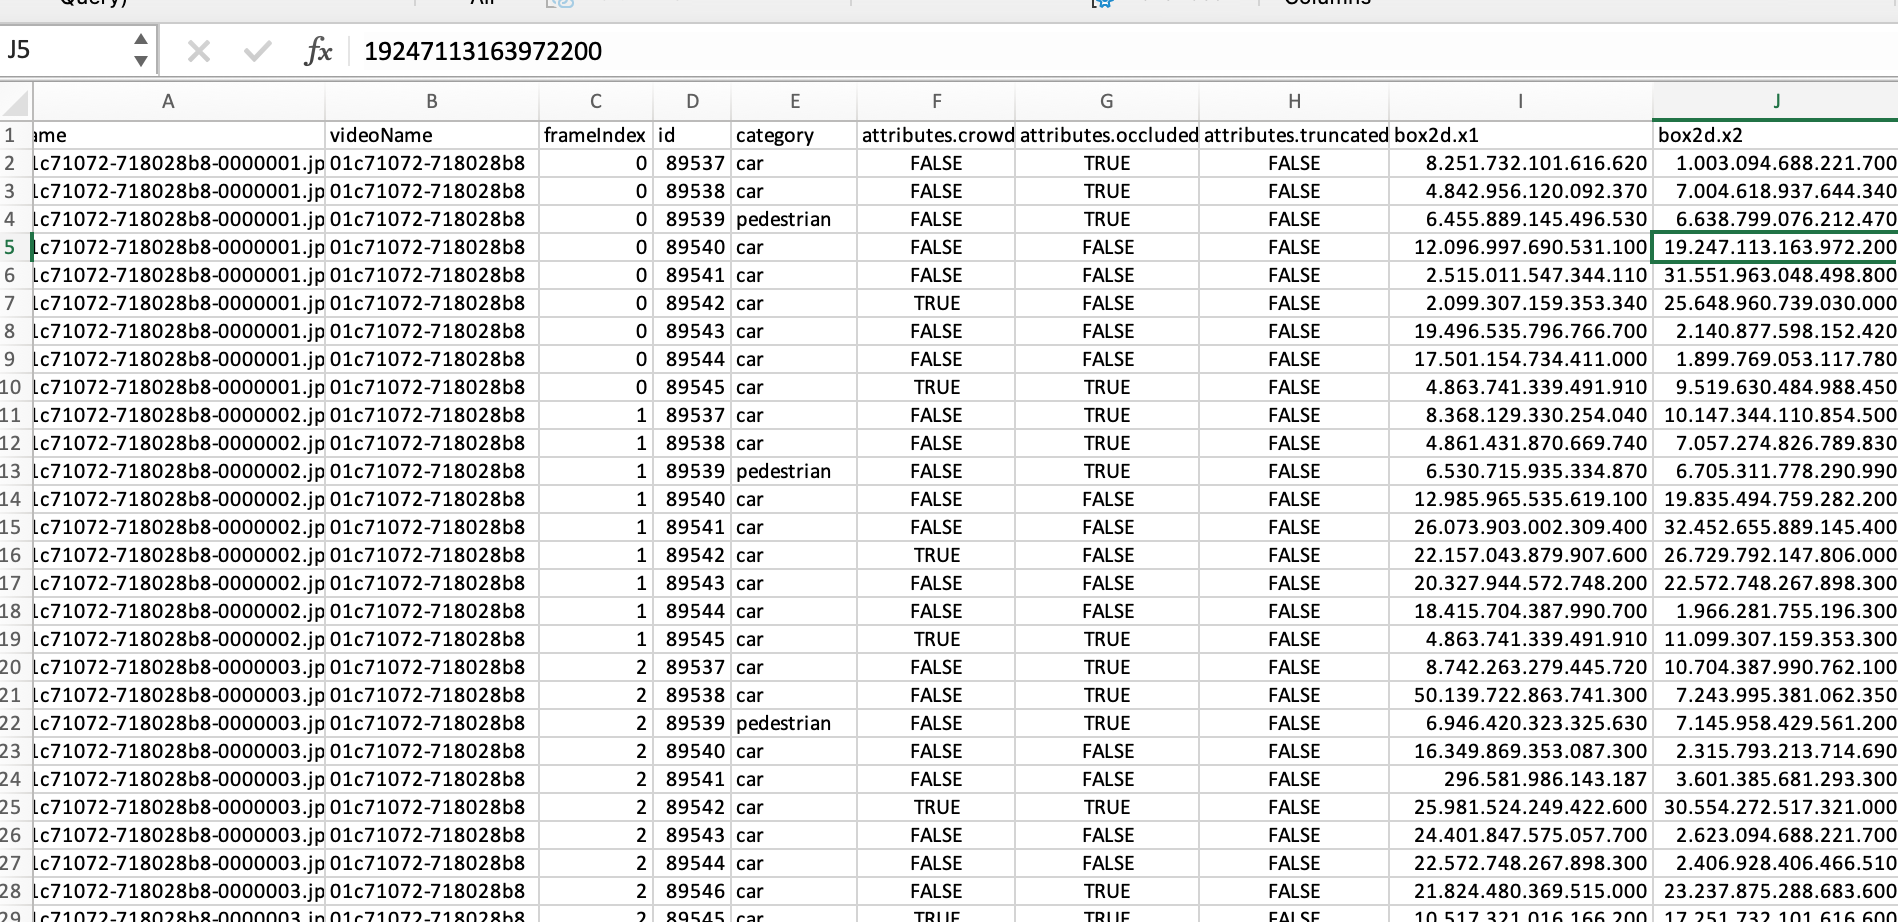

In [ ]:
labels = pd.read_csv('https://api.uinsgd.ac.id/salam/v1/data/mot_labels.csv',
                     low_memory=False)
video_labels = (
    labels.query('videoName == "026c7465-309f6d33"').reset_index(drop=True).copy()
)
video_labels["video_frame"] = (video_labels["frameIndex"] * 11.9).round().astype("int")

kita coba hitung resume pada kolom kategori untuk melihat label yang ada

In [ ]:
video_labels["category"].value_counts()

car              3030
pedestrian        847
bicycle           381
rider             320
truck             194
other vehicle     115
bus               109
other person       74
motorcycle         67
trailer            34
Name: category, dtype: int64

kita tarik semua frame yang ada pada video

In [ ]:
# Pull frame 1035

cap = cv2.VideoCapture("026c7465-309f6d33.mp4")
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0
for frame in range(n_frames):
    ret, img = cap.read()
    if ret == False:
        break
    if frame == 1035:
        break
cap.release()

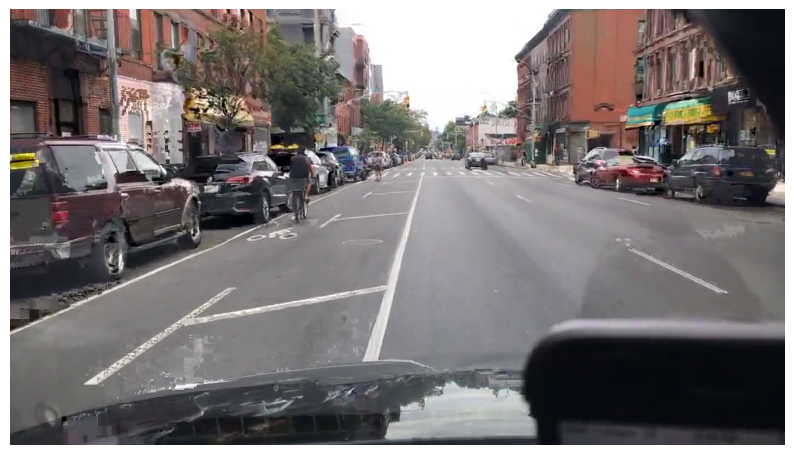

In [ ]:
display_cv2_img(img)

kita sisipkan label pada csv ke frame yang sudah kita tarik

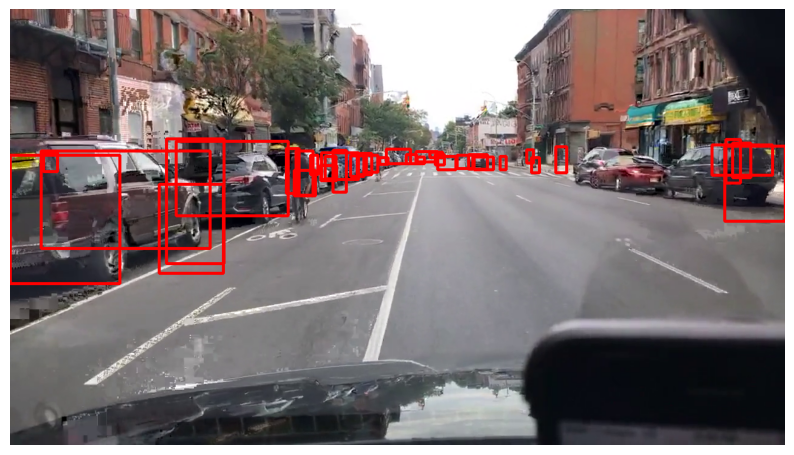

In [ ]:
img_example = img.copy()
frame_labels = video_labels.query('video_frame == 1035')
for i, d in frame_labels.iterrows():
    pt1 = int(d['box2d.x1']), int(d['box2d.y1'])
    pt2 = int(d['box2d.x2']), int(d['box2d.y2'])
    cv2.rectangle(img_example, pt1, pt2, (0, 0, 255), 3)

display_cv2_img(img_example)

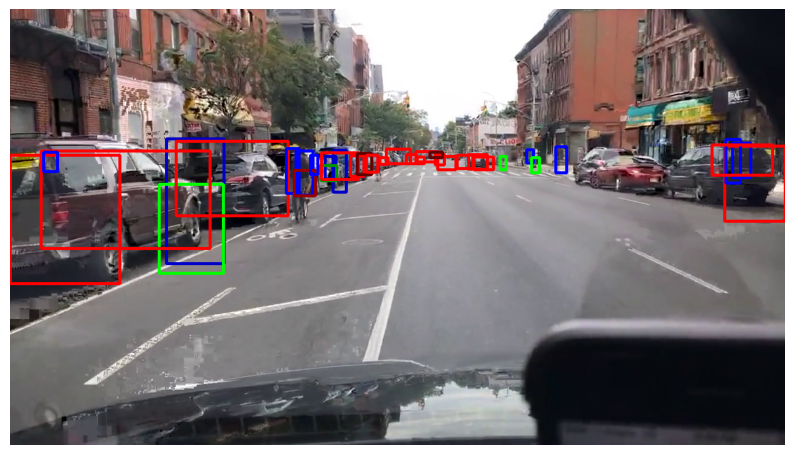

In [ ]:
color_map = {
    "car": (0, 0, 255),
    "truck": (0, 0, 100),
    "pedestrian": (255, 0, 0),
    "other vehicle": (0, 0, 150),
    "rider": (200, 0, 0),
    "bicycle": (0, 255, 0),
    "other person": (200, 0, 0),
    "trailer": (0, 150, 150),
    "motorcycle": (0, 150, 0),
    "bus": (0, 0, 100),
}

img_example = img.copy()
frame_labels = video_labels.query('video_frame == 1035')
for i, d in frame_labels.iterrows():
    pt1 = int(d['box2d.x1']), int(d['box2d.y1'])
    pt2 = int(d['box2d.x2']), int(d['box2d.y2'])
    color = color_map[d['category']]
    cv2.rectangle(img_example, pt1, pt2, color, 3)

display_cv2_img(img_example)

#Memasukan Teks
supaya lebih informatif kita sisipkan teks pada bounding box label yang sudah kita tandai untuk memudahkan orang mengenali kategori setiap box

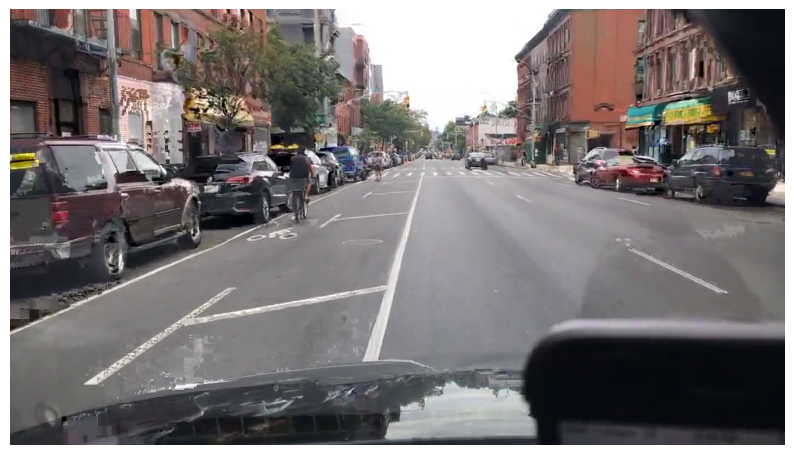

In [ ]:
frame_labels = video_labels.query("video_frame == @frame")
font = cv2.FONT_HERSHEY_TRIPLEX
img_example = img.copy()
for i, d in frame_labels.iterrows():
    pt1 = int(d["box2d.x1"]), int(d["box2d.y1"])
    pt2 = int(d["box2d.x2"]), int(d["box2d.y2"])
    color = color_map[d["category"]]
    img_example = cv2.rectangle(img_example, pt1, pt2, color, 3)
    pt_text = int(d["box2d.x1"]) + 5, int(d["box2d.y1"] + 10)
    img_example = cv2.putText(img_example, d["category"], pt_text, font, 0.5, color)
display_cv2_img(img_example)
cap.release()

#Label dan output Video yang di Anotasi

In [ ]:
def add_annotations(img, frame, video_labels):
    max_frame = video_labels.query("video_frame <= @frame")["video_frame"].max()
    frame_labels = video_labels.query("video_frame == @max_frame")
    for i, d in frame_labels.iterrows():
        pt1 = int(d["box2d.x1"]), int(d["box2d.y1"])
        pt2 = int(d["box2d.x2"]), int(d["box2d.y2"])
        color = color_map[d["category"]]
        img = cv2.rectangle(img, pt1, pt2, color, 3)
    return img

In [ ]:
!rm -r out_test.mp4

rm: cannot remove 'out_test.mp4': No such file or directory


langkah selanjut nya kita build hasil frame yang sudah di kasih bounding box label dan text yang kemudian dijadikan sebuah video

In [ ]:
VIDEO_CODEC = "mp4v"
fps = 59.94
width = 1280
height = 720
out = cv2.VideoWriter("out_test.mp4",
                cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                fps,
                (width, height))

cap = cv2.VideoCapture("026c7465-309f6d33.mp4")
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for frame in tqdm(range(n_frames), total=n_frames):
    ret, img = cap.read()
    if ret == False:
        break
    img = add_annotations(img, frame, video_labels)
    out.write(img)
out.release()
cap.release()

100%|██████████| 902/902 [00:18<00:00, 48.01it/s]


In [ ]:
!ls -GFlash -color

total 39M
4.0K drwxr-xr-x 1 root 4.0K Jun  5 17:11 sample_data/
 32M -rw-r--r-- 1 root  32M Jun  7 06:46 out_test.mp4
8.0K drwxr-xr-x 1 root 4.0K Jun  7 06:28 .config/
6.4M -rw-r--r-- 1 root 6.4M Jun  7 06:25 026c7465-309f6d33.mp4
4.0K drwxr-xr-x 1 root 4.0K Jun  7 06:24 ../
8.0K drwxr-xr-x 1 root 4.0K Jun  7 06:46 ./


In [ ]:
tmp_output_path = "out_test.mp4"
output_path = "out_test_compressed.mp4"
subprocess.run(
    [
        "ffmpeg",
        "-i",
        tmp_output_path,
        "-crf",
        "18",
        "-preset",
        "veryfast",
        "-vcodec",
        "libx264",
        output_path,
        '-loglevel',
        'quiet'
    ]
)

CompletedProcess(args=['ffmpeg', '-i', 'out_test.mp4', '-crf', '18', '-preset', 'veryfast', '-vcodec', 'libx264', 'out_test_compressed.mp4', '-loglevel', 'quiet'], returncode=0)

In [ ]:
!ls -GFlash --color

total 53M
8.0K drwxr-xr-x 1 root 4.0K Jun  7 06:46 ./
4.0K drwxr-xr-x 1 root 4.0K Jun  7 06:18 ../
6.4M -rw-r--r-- 1 root 6.4M Jun  7 06:25 026c7465-309f6d33.mp4
8.0K drwxr-xr-x 1 root 4.0K Jun  7 06:28 .config/
 15M -rw-r--r-- 1 root  15M Jun  7 06:46 out_test_compressed.mp4
 32M -rw-r--r-- 1 root  32M Jun  7 06:46 out_test.mp4
4.0K drwxr-xr-x 1 root 4.0K Jun  5 16:31 sample_data/


video yang sudah di annotasi sudah selesai. pada video ini terlihat objek mobil dan pejalan kaki akan terdeteksi dengan adanya bounding box beserta text yang ada pada bounding box tersebut

In [ ]:
from kora.drive import upload_public
url = upload_public('out_test_compressed.mp4')
# then display it
from IPython.display import HTML
HTML(f"""<video src={url} width=500 controls/>""")

#Tugas !!!
Buatlah coding sederhana pada python (silahkan gunakan library yang ada pada python) yang bisa membuat pengenalan objek pada bagian wajah.

jangan lupa beri penjelasan dari setiap bari coding yang anda buat.



Catatan:

Yang di upload berupa link google colab hasil coding dan di upload di LMS di form tugas yang sudah disediakan

